# Data Analysis

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np

## Load Data

In [2]:
# Load the Drive helper and mount

# This will prompt for authorization.
drive.mount('/content/drive')

project_folder = '/content/drive/My Drive/AML-Project-Frigerio-Napoli-Tremolada'

df_train = pd.read_csv(f'{project_folder}/train.csv')
df_train.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(159571, 8)

Merge test data with labels

In [3]:
test_data = pd.read_csv(f'{project_folder}/test.csv')
test_labels = pd.read_csv(f'{project_folder}/test_labels.csv')
df_test = pd.merge(test_data, test_labels, on='id')
df_test.shape

(153164, 8)

In [4]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]

Remove all samples whose labels are negative (as they're not used for scoring)

In [5]:
df_test = df_test[(df_test[labels] >= 0).all(1)]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])
df_test.shape

(63978, 8)

## Label Distribution

Trainset label distribution:

In [6]:
for label in labels:
  print(df_train[label].value_counts(normalize=True))

0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


Testset label distribution:

In [7]:
for label in labels:
  print(df_test[label].value_counts(normalize=True))

0    0.904811
1    0.095189
Name: toxic, dtype: float64
0    0.994264
1    0.005736
Name: severe_toxic, dtype: float64
0    0.942308
1    0.057692
Name: obscene, dtype: float64
0    0.996702
1    0.003298
Name: threat, dtype: float64
0    0.946435
1    0.053565
Name: insult, dtype: float64
0    0.988871
1    0.011129
Name: identity_hate, dtype: float64


In [8]:
from sklearn.model_selection import train_test_split

X = df_train["comment_text"]
y = df_train[labels].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["comment_text"]
y_test = df_test[labels].values

Train and validation label distribution after the split

In [9]:
def print_labels_distribution(y):
  counts = np.array([0, 0, 0, 0, 0, 0])
  totals = np.array([len(y)] * 6)
  for ls in y:
    counts += ls
  ratios = counts / totals
  for l, c, r in zip(labels, counts, ratios):
    print(f'{l:<15}: {c:>5}\t{r:.4f}\t{1-r:.4f}')

print('Y Train Distribution')
print_labels_distribution(y_train)
print()
print('Y Val Distribution')
print_labels_distribution(y_val)
print()
print('Y Test Distribution')
print_labels_distribution(y_test)

Y Train Distribution
toxic          : 12238	0.0959	0.9041
severe_toxic   :  1274	0.0100	0.9900
obscene        :  6734	0.0528	0.9472
threat         :   404	0.0032	0.9968
insult         :  6263	0.0491	0.9509
identity_hate  :  1111	0.0087	0.9913

Y Val Distribution
toxic          :  3056	0.0958	0.9042
severe_toxic   :   321	0.0101	0.9899
obscene        :  1715	0.0537	0.9463
threat         :    74	0.0023	0.9977
insult         :  1614	0.0506	0.9494
identity_hate  :   294	0.0092	0.9908

Y Test Distribution
toxic          :  6090	0.0952	0.9048
severe_toxic   :   367	0.0057	0.9943
obscene        :  3691	0.0577	0.9423
threat         :   211	0.0033	0.9967
insult         :  3427	0.0536	0.9464
identity_hate  :   712	0.0111	0.9889


## Preprocessing

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess(text):
  text = text.lower() # convert text to lowercase
  text = re.sub(r'\d+', '', text) # remove numbers
  text = str(text).replace("\n", " ") # remove newline characters
  text = re.sub(r'[^\w\s]', '', text) # Removing any non-alphanumeric characters (except spaces)
  text = text.replace("_", " ")
  text = text.strip() # remove whitespaces
  text = re.sub("([^\x00-\x7F])+"," ",text) # Removing any non-ASCII characters

  # remove stop words
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_tokens = [token.lower() for token in word_tokens if token.lower() not in stop_words]

  # Lemmatize the tokens
  lemmatizer=WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  # Join the tokens back into a string
  preprocessed_text = " ".join(lemmatized_tokens)

  return preprocessed_text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
X_train_pp = X_train.apply(preprocess)
X_val_pp = X_val.apply(preprocess)
X_test_pp = X_test.apply(preprocess)

AN example of the preprocessing applied:

In [12]:
print(X_train[1])
print(X_train_pp[1])


D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
daww match background colour im seemingly stuck thanks talk january utc


The value for the max lenght during the tokenization phase has to be decided based on the length of the comments in the whole dataset

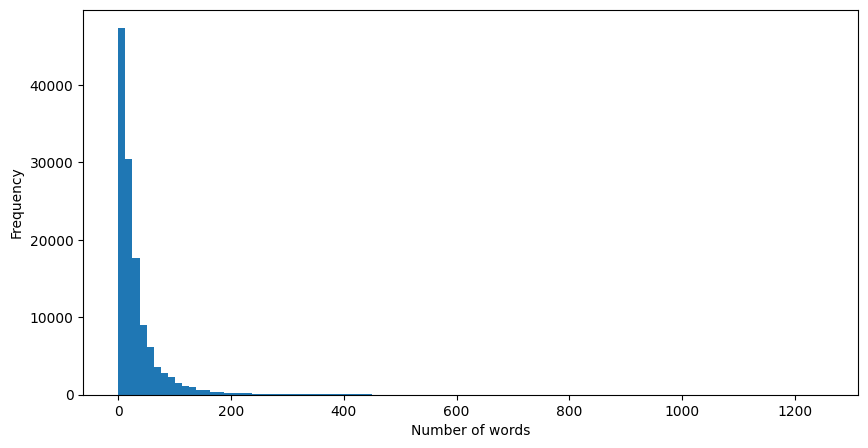

1.9920724446951181
1250
317.41329138812426


In [13]:
import matplotlib.pyplot as plt

# Count the number of words in each comment
lengths = [len(t) for t in X_train_pp.str.split()]

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(lengths, bins=100)
ax.set_xlabel('Number of words')
ax.set_ylabel('Frequency')
plt.show()

# count how many comments are completely representend if we chose length 200
uncovered_comments_lengths = [len for len in lengths if len > 200]
print(len(uncovered_comments_lengths)*100/len(X_train_pp)) # 1.98% of comments will be truncated

# how much will they be trucated?
print(max(uncovered_comments_lengths)) # longest comment in train set
print(sum(uncovered_comments_lengths)/len(uncovered_comments_lengths)) # average length of comments longer than 200

## Tokenization and Vectorization

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

max_len = 200
vocabulary_size = 200000

auto = tf.data.AUTOTUNE
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=1, output_mode="int",
    output_sequence_length=max_len
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(X_train_pp)

In [15]:
X_train_vc = text_vectorizer(X_train_pp)
X_val_vc = text_vectorizer(X_val_pp)
X_test_vc = text_vectorizer(X_test_pp)

In [16]:
print(X_train_vc[0])
print(X_val_vc[0])
print(X_test_vc[0])

tf.Tensor(
[10581  7686  3058  3703 10581  7686  3703   260 10581  7686  7951   630
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [17]:
from operator import itemgetter

def words_in_vocabulary(pos, vocabulary: set):
  '''
     Check the presence of words of comments with a certain label within the
     vocabulary.
  '''
  in_vocab = list()
  not_vocab = list()
  # Get the indices of comments with label in position pos set to 1
  toxic_indices = [i for i, x in enumerate(np.array(y_train)) if x[pos]==1]
  toxic_comments = np.array(X_train_pp)[np.array(toxic_indices)]
  for comment in toxic_comments:
    for word in comment.split():
        if word in vocabulary:
          in_vocab.append(word)
        else:
          not_vocab.append(word)
  return in_vocab, not_vocab


In [18]:
vocabulary = text_vectorizer.get_vocabulary()

In [19]:
print('A' if y_train[0][2] == 1 else 'B')
print(y_train[23])

B
[1 0 1 0 1 0]


In [20]:
from collections import Counter

toxic_vocab, toxic_not_vocab = words_in_vocabulary(0, vocabulary)
print(Counter(toxic_not_vocab))

sev_toxic_vocab, sev_toxic_not_vocab = words_in_vocabulary(1, vocabulary)
print(Counter(sev_toxic_not_vocab))

obscene_vocab, obscene_not_vocab = words_in_vocabulary(2, vocabulary)
print(Counter(obscene_not_vocab))

threat_vocab, threat_not_vocab = words_in_vocabulary(3, vocabulary)
print(Counter(threat_not_vocab))

insult_vocab, insult_not_vocab = words_in_vocabulary(4, vocabulary)
print(Counter(insult_not_vocab))

id_hate_vocab, id_hate_not_vocab = words_in_vocabulary(5, vocabulary)
print(Counter(id_hate_not_vocab))



Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


Tutte le parole vengono correttamente salvate nel vocabolario

## 6B Wikipedia 300D Embedding

In [21]:
path_to_glove_file = '/content/drive/My Drive/AML-toxic/glove/glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

voc = text_vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Found 400001 word vectors.
Converted 74536 words (108835 misses)


Gli embedding di glove non hanno i vettori per un ampia porzione del vocabolario

In [22]:
def words_in_embedding(words):
  in_emb = list()
  not_emb = list()
  for word in words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      in_emb.append(word)
    else:
      not_emb.append(word)

  return Counter(in_emb), Counter(not_emb)

In [23]:
# Find words in comments that are in the vocabulary but not in the embedding
toxic_emb, toxic_not_emb = words_in_embedding(toxic_vocab)

threat_emb, threat_not_emb = words_in_embedding(threat_vocab)

insult_emb, insult_not_emb = words_in_embedding(insult_vocab)

obscene_emb, obscene_not_emb = words_in_embedding(obscene_vocab)

id_hate_emb, id_hate_not_emb = words_in_embedding(id_hate_vocab)

sev_toxic_emb, sev_toxic_not_emb = words_in_embedding(sev_toxic_vocab)

In [24]:
def add_embedding(words):
  for word, _ in words:
    current_vocab = ''
    for vocab in embeddings_index.keys():
      if vocab in word and len(vocab) > len(current_vocab):
        current_vocab = vocab
    if current_vocab != '':
      embedding_vector = embeddings_index.get(vocab)
      i = word_index[word]
      embedding_matrix[i] = embedding_vector

Stampa delle parole piu' frequenti per cui l'embedding non e' disponibile.

In [25]:
# We observe that the most common words not captured by Glove embeddings are compound words.
# If the words obtained by splitting the compound word are in the Glove embedding, we should add this operation to the preprocessing phase.
# However, the splitting operation is quite hard so we assign to the compound word the embedding of the longest substring that is in the Glove embeddings.

most_common_toxic_words = sorted(toxic_not_emb.items(), key=lambda item: item[1], reverse=True)[:50]
print(most_common_toxic_words)
add_embedding(most_common_toxic_words)

most_common_threat_words = sorted(threat_not_emb.items(), key=lambda item: item[1], reverse=True)[:50]
print(most_common_threat_words)
add_embedding(most_common_threat_words)

most_common_insult_words = sorted(insult_not_emb.items(), key=lambda item: item[1], reverse=True)[:50]
print(most_common_insult_words)
add_embedding(most_common_insult_words)

most_common_obscene_words = sorted(obscene_not_emb.items(), key=lambda item: item[1], reverse=True)[:50]
print(most_common_obscene_words)
add_embedding(most_common_obscene_words)

most_common_id_hate_words = sorted(id_hate_not_emb.items(), key=lambda item: item[1], reverse=True)[:50]
print(most_common_id_hate_words)
add_embedding(most_common_id_hate_words)

most_common_sev_toxic_words = sorted(sev_toxic_not_emb.items(), key=lambda item: item[1], reverse=True)[:50]
print(most_common_sev_toxic_words)
add_embedding(most_common_sev_toxic_words)

[('fucksex', 624), ('yourselfgo', 621), ('buttsecks', 498), ('noobs', 457), ('youi', 454), ('cocksucker', 445), ('mothjer', 391), ('bollock', 340), ('bitchesfuck', 333), ('sexsex', 332), ('youfuck', 314), ('cocksucking', 288), ('criminalwar', 279), ('assfuck', 278), ('bunksteve', 278), ('marcolfuck', 260), ('penissmall', 249), ('proassadhanibalyoure', 239), ('notrhbysouthbanof', 228), ('cuntbag', 226), ('fack', 223), ('youbollocks', 217), ('youve', 211), ('ancestryfuckoffjewish', 207), ('useredgar', 204), ('fggt', 186), ('jdelanoy', 184), ('shitfuck', 182), ('centraliststupid', 179), ('usernhrhs', 172), ('lmao', 166), ('ricehey', 163), ('bleachanhero', 148), ('dumbass', 147), ('aidsaids', 146), ('dickhead', 129), ('shithole', 128), ('haahhahahah', 128), ('yaaa', 128), ('yaaaaah', 128), ('administratorprick', 126), ('dpenis', 118), ('computeri', 112), ('cuntliz', 111), ('shitheadi', 108), ('itsuck', 101), ('cougaryou', 101), ('rvv', 97), ('gayfrozen', 93), ('millionsix', 93)]
[('supertr

In [26]:
i = word_index['yourselfgo']
print(embedding_matrix[i])

[ 0.42919099 -0.29689699  0.15011001  0.24520101 -0.00352027 -0.0576971
  0.1409     -0.222294    0.22115301  0.76721799 -0.0772662  -0.0710635
  0.0629486  -0.22017901 -0.108197   -0.30141899  0.232164    0.168669
 -0.00452476  0.168254   -0.0579106  -0.0362662  -0.27346399 -0.162976
  0.239398   -0.0119058   0.044685    0.105252    0.102867   -0.0232984
 -0.0114432  -0.38167301  0.06122     0.0170547   0.415463   -0.109101
  0.0959916   0.19148999 -0.00752907 -0.194603   -0.0431976   0.25978801
  0.00527856 -0.183626    0.225188   -0.0187726  -0.158172   -0.58693701
  0.249259   -0.130252   -0.0537497   0.0315535  -0.18561999  0.0610198
 -0.0850566  -0.0965162   0.27862099 -0.247254   -0.15389501  0.0418453
  0.0704212  -0.062286   -0.284913    0.0152124   0.14400201  0.33590201
 -0.288315   -0.00253548 -0.0876423  -0.0574409   0.00670068 -0.0753335
 -0.0677815  -0.056624    0.19295999  0.0250159  -0.39188001 -0.15927801
  0.26122999  0.10221     0.0877169   0.0433055  -0.179803   -0

## 27B Twitter 100D Embedding

In [27]:
embedding_27_dim = 100
path_to_glove_27_file = f'/content/drive/My Drive/AML-toxic/glove/glove.twitter.27B.{embedding_27_dim}d.txt'

embeddings_27_index = {}
with open(path_to_glove_27_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_27_index[word] = coefs

print("Found %s word vectors." % len(embeddings_27_index))

voc_27 = text_vectorizer.get_vocabulary()
word_index_27 = dict(zip(voc, range(len(voc_27))))

num_tokens_27 = len(voc_27) + 2

hits_27 = 0
misses_27 = 0

# Prepare embedding matrix
embedding_27_matrix = np.zeros((num_tokens_27, embedding_27_dim))
for word, i in word_index_27.items():
    embedding_vector = embeddings_27_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_27_matrix[i] = embedding_vector
        hits_27 += 1
    else:
        misses_27 += 1
print("Converted %d words (%d misses)" % (hits_27, misses_27))

Found 1193515 word vectors.
Converted 66571 words (116800 misses)


Anche usando un GloVe trainato su piu' vocaboli il numero di parole convertite rimane simile

## SMOTE

In [28]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified

  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices


def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    # new_X = pd.concat([X, new_X], axis=0)
    # target = pd.concat([y, target], axis=0)
    return new_X, target

X_sub, y_sub = get_minority_instace(pd.DataFrame(X_train_vc), pd.DataFrame(y_train))   #Getting minority instance of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 2000)

In [29]:
print(X_sub.shape)
print(X_res.shape)
print(y_sub.shape)
print(y_res.shape)

(2380, 200)
(2000, 200)
(2380, 6)
(2000, 6)


In [30]:
for x in X_res.values[:5]:
  print(x)

[  183.2799331    773.23444729 22523.38556386  1918.16649734
   736.91404589   402.9567442    638.93483754   275.99777
  2076.88321923  9123.10628727   425.0365658    204.2383498
    82.799331     402.9567442    150.41878465 15026.69858752
    23.45981045     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.           

In [31]:
print('Y Train Distribution')
print_labels_distribution(y_train)
y_train.shape

Y Train Distribution
toxic          : 12238	0.0959	0.9041
severe_toxic   :  1274	0.0100	0.9900
obscene        :  6734	0.0528	0.9472
threat         :   404	0.0032	0.9968
insult         :  6263	0.0491	0.9509
identity_hate  :  1111	0.0087	0.9913


(127656, 6)

In [32]:
y_res_proc = y_res.to_numpy().astype(int)
print_labels_distribution(y_res_proc)
y_res_proc.shape

toxic          :  1997	0.9985	0.0015
severe_toxic   :  1179	0.5895	0.4105
obscene        :  1881	0.9405	0.0595
threat         :    82	0.0410	0.9590
insult         :  1895	0.9475	0.0525
identity_hate  :   887	0.4435	0.5565


(2000, 6)

In [33]:
y_aug = pd.concat([y_res, pd.DataFrame(y_train)]).to_numpy().astype(int)
print_labels_distribution(y_aug)
y_aug.shape

toxic          : 14235	0.1098	0.8902
severe_toxic   :  2453	0.0189	0.9811
obscene        :  8615	0.0664	0.9336
threat         :   486	0.0037	0.9963
insult         :  8158	0.0629	0.9371
identity_hate  :  1998	0.0154	0.9846


(129656, 6)

In [34]:
X_res_converted = np.round(X_res.to_numpy().astype(int)).astype(int)
X_res_positive = np.clip(X_res_converted, 0, len(voc))
X_aug = np.vstack([X_train_vc, X_res_converted])
X_aug.shape

(129656, 200)

In [35]:
for x in X_res_positive[:5]:
  print(x)

[  183   773 22523  1918   736   402   638   275  2076  9123   425   204
    82   402   150 15026    23     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [36]:
ds_train_aug = tf.data.Dataset.from_tensor_slices((X_aug, y_aug)).shuffle(130000)
# ds_train.save(f'/content/drive/My Drive/AML-toxic/dataset/train_tokenized_aug-{max_len}-{vocabulary_size}')

CNN test with AUG trainset

In [37]:
from tensorflow import keras

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

inputs = keras.Input(shape=(200,))
embedding = embedding_layer(inputs)
# x = keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation = 'relu')(embedding)
# x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Conv1D(500, 5, activation = 'relu')(embedding)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(500, activation = 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(len(labels), activation = 'sigmoid')(x)

model = keras.Model(inputs, outputs)

In [38]:
auc_metric = keras.metrics.AUC(multi_label=True)
model.summary()
model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy", auc_metric]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          55011900  
                                                                 
 conv1d (Conv1D)             (None, 196, 500)          750500    
                                                                 
 global_max_pooling1d (Glob  (None, 500)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 500)               250500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                             

In [39]:
ds_val = tf.data.Dataset.from_tensor_slices((X_val_vc, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_vc, y_test))

In [40]:
BATCH_SIZE = 64

ds_train_aug = ds_train_aug.cache().batch(BATCH_SIZE).prefetch(16)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(16)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(16)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(ds_train_aug, validation_data=ds_val, epochs=20, callbacks=[EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True)])

Epoch 1/20
2026/2026 [==============================] - 38s 15ms/step - loss: 0.1795 - binary_accuracy: 0.9535 - auc: 0.4977 - val_loss: 0.1423 - val_binary_accuracy: 0.9631 - val_auc: 0.5538
Epoch 2/20
2026/2026 [==============================] - 32s 16ms/step - loss: 0.1700 - binary_accuracy: 0.9538 - auc: 0.6001 - val_loss: 0.1420 - val_binary_accuracy: 0.9631 - val_auc: 0.5702
Epoch 3/20
2026/2026 [==============================] - 30s 15ms/step - loss: 0.1509 - binary_accuracy: 0.9538 - auc: 0.7718 - val_loss: 0.1606 - val_binary_accuracy: 0.9631 - val_auc: 0.5151


In [42]:
model.evaluate(ds_test)

1000/1000 [==============================] - 7s 6ms/step - loss: 0.1463 - binary_accuracy: 0.9622 - auc: 0.5609


[0.14626236259937286, 0.9622313380241394, 0.5608676075935364]